In [79]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set plot style
sns.set(style='whitegrid')

# Load the dataset
data = pd.read_csv('gld_price_data.csv')

# Display basic info and first few rows
print(data.info())
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB
None


,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [80]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index (optional, for visualization)
data.set_index('Date', inplace=True)

# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Drop rows with missing values (if any)
data.dropna(inplace=True)

# Create new features for better predictions
data['Gold_Silver_Ratio'] = data['GLD'] / data['SLV']  # Gold/Silver Ratio
data['Gold_5_MA'] = data['GLD'].rolling(window=5).mean()  # 5-day Moving Average
data['Gold_20_MA'] = data['GLD'].rolling(window=20).mean()  # 20-day Moving Average
data['Gold_Volatility'] = data['GLD'].rolling(window=5).std()  # 5-day Volatility

# Drop rows with NaN values caused by rolling calculations
data.dropna(inplace=True)

# Display the processed dataset
data.head()


Missing values:
 SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64


,SPX,GLD,USO,SLV,EUR/USD,Gold_Silver_Ratio,Gold_5_MA,Gold_20_MA,Gold_Volatility
Date,,,,,,,,,
2008-01-30,1355.810059,92.059998,73.080002,16.674999,1.483107,5.520840,91.068001,88.0020,0.869176
2008-01-31,1378.550049,91.400002,72.349998,16.818001,1.486503,5.434653,91.332001,88.3290,0.672211
2008-02-01,1395.420044,89.349998,70.470001,16.618999,1.479991,5.376377,91.142000,88.5180,1.059515
2008-02-04,1380.819946,89.099998,71.370003,16.514999,1.482800,5.395096,90.612000,88.7165,1.312049
2008-02-05,1336.640015,87.680000,70.150002,16.167000,1.463807,5.423393,89.917999,88.8620,1.787798


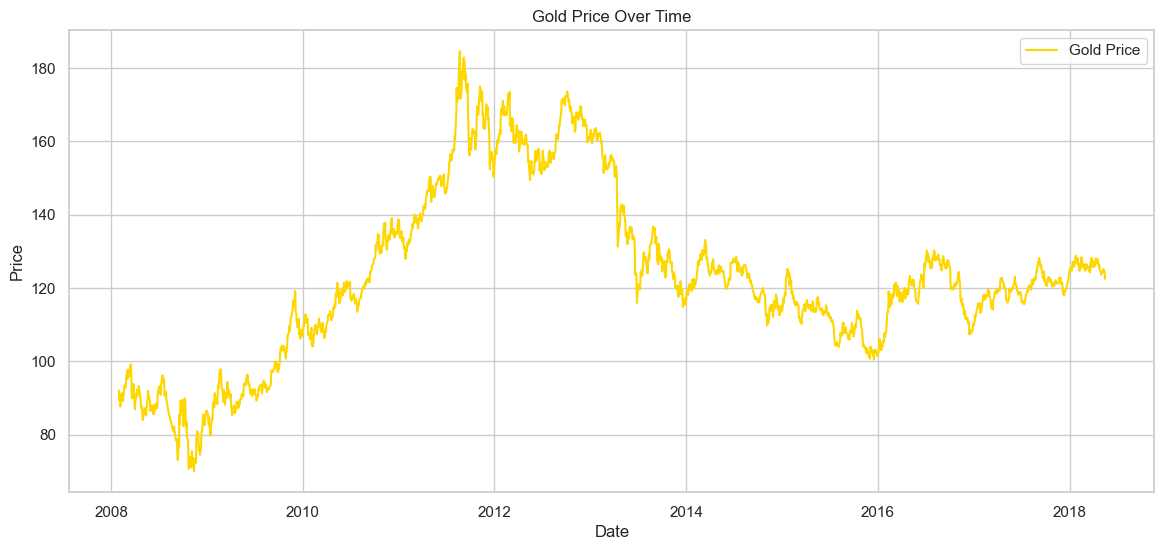

In [81]:
# Plot the gold price over time
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['GLD'], label='Gold Price', color='gold')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [84]:
# Define features and target variable
features = ['SLV', 'Gold_Silver_Ratio', 'Gold_5_MA', 'Gold_20_MA', 'Gold_Volatility']
X = data[features]
y = data['GLD']


X_train = X[data.index < '2018-01-01']
y_train = y[data.index < '2018-01-01']
X_test = X[data.index >= '2018-01-01']
y_test = y[data.index >= '2018-01-01']

# Verify shapes
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (2184, 5) (2184,)
Testing data shape: (87, 5) (87,)


In [85]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")


Mean Squared Error: 0.97
Mean Absolute Error: 0.78


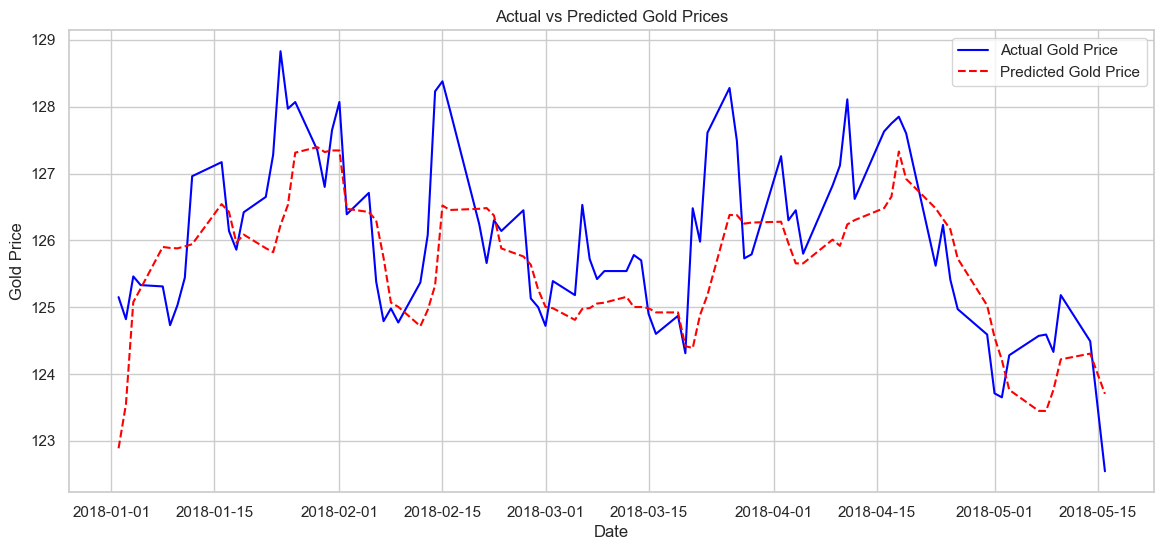

In [86]:
# Create a DataFrame to compare actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(results.index, results['Actual'], label='Actual Gold Price', color='blue')
plt.plot(results.index, results['Predicted'], label='Predicted Gold Price', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Gold Prices')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()


C:\Users\Leo\AppData\Local\Temp\ipykernel_27880\1366741072.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


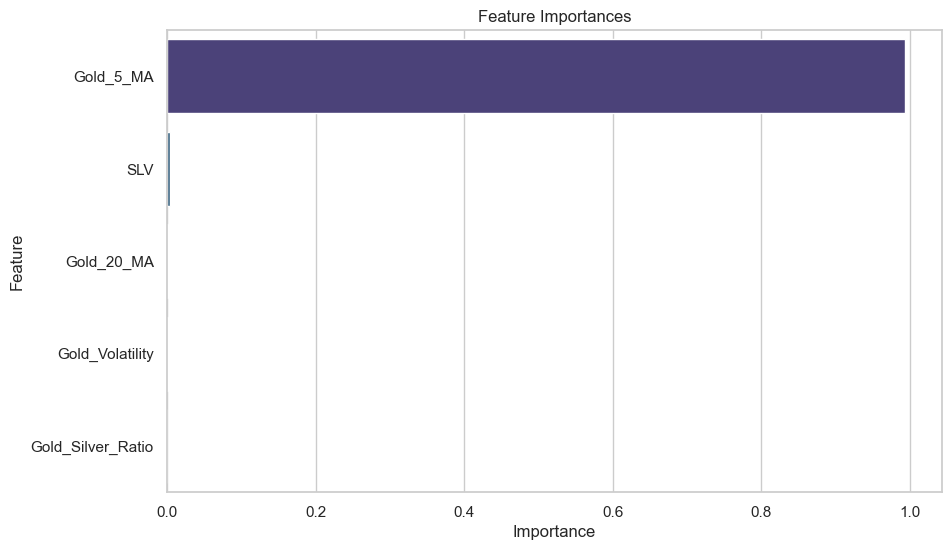

In [87]:
# Get feature importances from the model
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [90]:
# Predict gold prices for specific dates in 2021
specific_dates = ['2018-01-16', '2018-05-14', '2018-3-15']
specific_data = X.loc[specific_dates]

# Predict prices
predicted_prices = rf_model.predict(specific_data)

# Display predictions
for date, price in zip(specific_dates, predicted_prices):
    print(f"Predicted Gold Price on {date}: {price:.2f}")


Predicted Gold Price on 2018-01-16: 126.54
Predicted Gold Price on 2018-05-14: 124.30
Predicted Gold Price on 2018-3-15: 124.98
